# Visualizing Multiple Contrasts

> Explanation of how to use forest_plot for contrast objects e.g delta-delta and mini-meta or regular deltas.

- order: 11

In DABEST **XXX**, we introduce two new ways of visualizing bootstrap distributions in more compact ways:
- forest plot
- vortexmap

## Load libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import dabest
from dabest.multi import combine, vortexmap

In [ ]:
def create_delta_dataset(N=20, 
                        seed=9999, 
                        second_quarter_adjustment=3, 
                        third_quarter_adjustment=-0.1,
                        scale2=1, initial_loc = 3):
    """Create a sample dataset for delta-delta analysis."""
    np.random.seed(seed)

    # Create samples
    y = norm.rvs(loc=initial_loc, scale=0.4, size=N*4)
    y[N:2*N] = norm.rvs(loc=initial_loc + second_quarter_adjustment, scale=scale2, size=N) 
    y[2*N:3*N] = norm.rvs(loc=initial_loc + third_quarter_adjustment, scale=0.4, size=N)
    y[3*N:4*N] = norm.rvs(loc=initial_loc, scale=0.4, size=N)

    # Treatment, Rep, Genotype, and ID columns
    treatment = np.repeat(['Placebo', 'Drug'], N*2).tolist()
    genotype = np.repeat(['W', 'M', 'W', 'M'], N).tolist()
    id_col = list(range(0, N*2)) * 2

    # Combine all columns into a DataFrame
    df = pd.DataFrame({
        'ID': id_col,
        'Genotype': genotype,
        'Treatment': treatment,
        'Tumor Size': y
    })

    return df

In [ ]:
df_drug1 = create_delta_dataset(seed=9999, second_quarter_adjustment=1, third_quarter_adjustment=-0.5)
df_drug2 = create_delta_dataset(seed=9999, second_quarter_adjustment=0.1, third_quarter_adjustment=-1)
df_drug3 = create_delta_dataset(seed=9999, second_quarter_adjustment=2, third_quarter_adjustment=-0.5)
df_drug4 = create_delta_dataset(seed=9999, second_quarter_adjustment=1, third_quarter_adjustment=-0.1, scale2=7)
df_drug5 = create_delta_dataset(seed=9999, second_quarter_adjustment=0.1, third_quarter_adjustment=-0.3, scale2=7)

In [ ]:
contrast1 = dabest.load(data=df_drug1, 
                       x=["Genotype", "Genotype"], 
                       y="Tumor Size", 
                       delta2=True, 
                       experiment="Treatment").hedges_g

contrast2 = dabest.load(data=df_drug2, 
                       x=["Genotype", "Genotype"], 
                       y="Tumor Size", 
                       delta2=True, 
                       experiment="Treatment").hedges_g

contrast3 = dabest.load(data=df_drug3, 
                       x=["Genotype", "Genotype"], 
                       y="Tumor Size", 
                       delta2=True, 
                       experiment="Treatment").hedges_g

contrast4 = dabest.load(data=df_drug4, 
                       x=["Genotype", "Genotype"], 
                       y="Tumor Size", 
                       delta2=True, 
                       experiment="Treatment").hedges_g

contrast5 = dabest.load(data=df_drug5, 
                       x=["Genotype", "Genotype"], 
                       y="Tumor Size", 
                       delta2=True, 
                       experiment="Treatment").hedges_g

contrasts = [contrast1, contrast2, contrast3, contrast4, contrast5]
contrasts2 = [[contrast1, contrast2, contrast3, contrast4, contrast5], [contrast1, contrast2, contrast3, contrast4, contrast5]]

MultiContrast with 5 contrasts: ['Drug1', 'Drug2', 'Drug3', 'Drug4', 'Drug5']


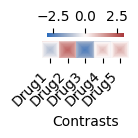

In [ ]:
multi = combine(contrasts, labels=["Drug1", "Drug2", "Drug3", "Drug4", "Drug5"])
print(multi)
fig, ax, mean_delta = vortexmap(
    multi,
    n=30,  # Larger spiral size
    vmax=3, vmin=-3,  # Extended color range
    reverse_neg=True,
    abs_rank=False,
    chop_tail=5  # Remove 5% extreme values
)
# plt.title("Customized Vortexmap")
plt.show()

In [ ]:
contrasts_big = [[None for _ in range(10)] for _ in range(6)]
labels_big = [["Genotype 1", "Tx 1", "Tx2", "Tx3", "Tx4", "Tx5", "Tx6", "Tx7", "Tx8", "Tx9" , "Tx10"], 
             ["Genotype 2", "Tx1", "Tx2", "Tx3", "Tx4", "Tx5", "Tx6", "Tx7", "Tx8", "Tx9" , "Tx10"],
             ["Genotype 3", "Tx1", "Tx2", "Tx3", "Tx4", "Tx5", "Tx6", "Tx7", "Tx8", "Tx9" , "Tx10"],
             ["Genotype 4", "Tx1", "Tx2", "Tx3", "Tx4", "Tx5", "Tx6", "Tx7", "Tx8", "Tx9" , "Tx10"],
             ["Genotype 5", "Tx1", "Tx2", "Tx3", "Tx4", "Tx5", "Tx6", "Tx7", "Tx8", "Tx9" , "Tx10"],
             ["Genotype 6", "Tx1", "Tx2", "Tx3", "Tx4", "Tx5", "Tx6", "Tx7", "Tx8", "Tx9" , "Tx10"],]
second_quarter_adjustment_big = [[1, 0, 1, 1, 1, -1, 0,0, 0, .4], 
             [1, 0, 2, 1, 1, -1, 0,0, 1.5, .4],
             [1, 0, 1, 2, 1, 1, .5,0, 1, .4],
             [1, 0, 2, 1, 1, -0.5, 0,0, 3, .4],
             [1, 0, 2, 4, 1, -0.5, 0,0, 1, .4],
             [1, 0, 2, .7, 1, -0.5, 0,0, 3, .4],
                                ]
scale2_big = [[1, 10, 1, 1000, 1, 2, 1,1, 0, .4], 
             [1, 0, 8, 3, 1, 4, 7,1, 1000, 2],
             [15, 3, 1, 2, 1, 1, 90,1, 7, 2],
             [1, 0, 1, 330, 1, 6,1,1, 3, .4],
             [90, 0, 700, 1, 1, 2,1,1, 90, .4],
             [1, 0, 1, 4, 1, 4,1,1, 3, .4],
             ]
seeds = [1, 1000, 20, 9999, 109, 5320]

for i in range(len(labels_big)):
    for j in range(len(labels_big[0])-1):
        df = create_delta_dataset(seed=seeds[i], 
                                  second_quarter_adjustment=second_quarter_adjustment_big[i][j],
                                  third_quarter_adjustment=-0.1, 
                                 initial_loc = 0)
        contrasts_big[i][j] = dabest.load(data=df, 
                       x=["Genotype", "Genotype"], 
                       y="Tumor Size", 
                       delta2=True, 
                       experiment="Treatment").hedges_g

multi_big = combine(contrasts_big, labels_big)


/Applications/anaconda3/envs/vortexmap/lib/python3.10/site-packages/dabest/_effsize_objects.py:306: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(
/Applications/anaconda3/envs/vortexmap/lib/python3.10/site-packages/dabest/_effsize_objects.py:306: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(


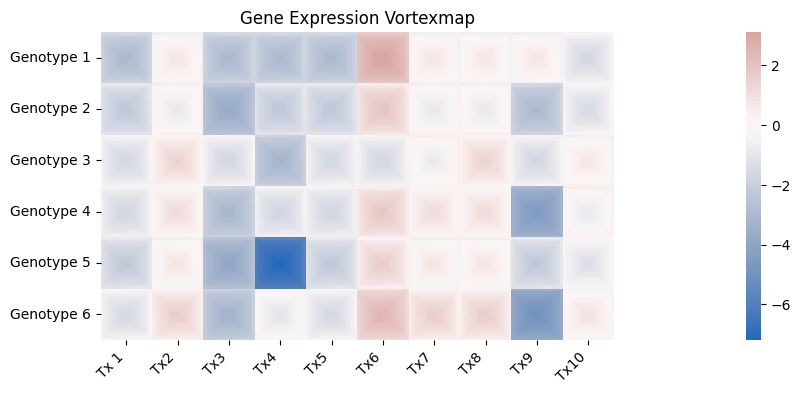

In [ ]:

fig, ax, mean_delta = vortexmap(
    multi_big,
    n=21,  # Larger spiral size
    vmax=None, vmin=None,  # Extended color range
    reverse_neg=True,
    abs_rank=False,
    chop_tail=5,  # Remove 5% extreme values
    fig_size = (10, 4)
)
plt.title("Gene Expression Vortexmap")
plt.show()
